In [118]:
%matplotlib inline
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['MKL_NUM_THREADS'] = '32'
os.environ['GOTO_NUM_THREADS'] = '32'
os.environ['OMP_NUM_THREADS'] = '32'
os.environ['openmp'] = 'True'


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import librosa
import numpy as np
import glob

import keras
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation

from IPython.display import Audio

In [74]:
descriptors_folder = 'Descriptores-cuts/'
npys = []
for file in glob.glob(descriptors_folder+'*.npy'):
    if not '_st' in file:
        x = np.load(file)
        npys.append(x)
X = np.hstack(npys).T
sounds = []
for filename in glob.glob('Cuts/*.wav'):
    x,fs = librosa.load(filename, sr = None)
    sounds.append(x[:22016])
    
S = np.vstack(sounds)
F = np.fft.fft(S)
F = F[:,:int(S.shape[1]/2)]
y = np.log10(abs(F)).clip(0)

In [75]:
X_mean = X.mean(0)
X_norm = X-X_mean
X_std = X_norm.std(0)
X_norm = X_norm/X_std
X_min = X_norm.min()
X_norm = X_norm - X_min

print(X_norm.min(), X_norm.max())

# y_min = y.min()
# y = y - y_min
# print(y_min, y.min(), y.max())

(0.0, 7.112608444722232)
(0.0, 0.0, 3.3850055904412075)


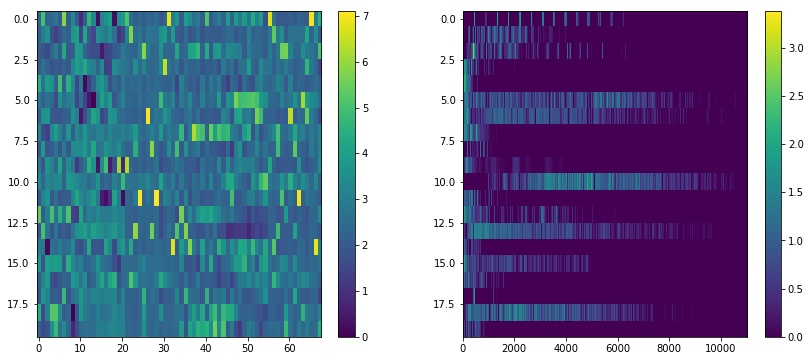

In [76]:
X_norm = X-X.mean(0)
X_norm = X_norm/X_norm.std(0)
X_norm = X_norm - X_norm.min()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(X_norm,aspect='auto')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(y,aspect='auto')
plt.colorbar()

In [ ]:
n_hidden = 2000

kinit = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)

model = Sequential()
model.add(Dense(n_hidden, input_dim=X.shape[1], kernel_initializer=kinit),)
model.add(Activation('relu'))
model.add(Dense(F.shape[1], input_dim=n_hidden, kernel_initializer=kinit),)
model.add(Activation('relu'))

sgd = SGD(lr=0.05, clipnorm=2.)

model.compile(loss='mean_squared_error', optimizer=sgd)

history = model.fit(X_norm,y, batch_size=4, epochs=100, verbose=1)

Epoch 1/100
20/20 [==============================] - 1s 66ms/step - loss: 25.4115
Epoch 2/100
20/20 [==============================] - 1s 26ms/step - loss: 17.7672
Epoch 3/100
20/20 [==============================] - 1s 26ms/step - loss: 12.1485
Epoch 4/100
20/20 [==============================] - 1s 31ms/step - loss: 8.0142
Epoch 5/100
20/20 [==============================] - 1s 26ms/step - loss: 5.1476
Epoch 6/100
20/20 [==============================] - 1s 26ms/step - loss: 3.2438
Epoch 7/100
20/20 [==============================] - 1s 26ms/step - loss: 2.0078
Epoch 8/100
20/20 [==============================] - 1s 27ms/step - loss: 1.2860
Epoch 9/100
20/20 [==============================] - 1s 34ms/step - loss: 0.8453
Epoch 10/100
20/20 [==============================] - 1s 32ms/step - loss: 0.6009
Epoch 11/100
20/20 [==============================] - 1s 30ms/step - loss: 0.4642
Epoch 12/100
20/20 [==============================] - 1s 30ms/step - loss: 0.3820
Epoch 13/100
20/20 [==

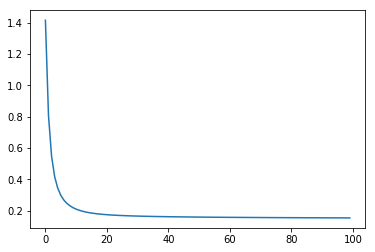

In [122]:
plt.plot(history.history['loss'])

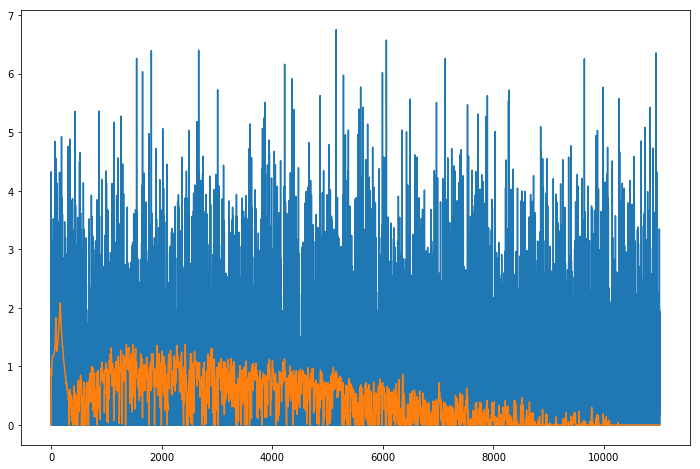

In [123]:
ix = 6
y_pred  = model.predict(X[ix:ix+1,:])
plt.figure(figsize=(12,8))
plt.plot(y_pred[0])
plt.plot(y[ix,:])

In [114]:
M =  10**y_pred[0]

phase = np.random.randn(M.size)
Fre = M*np.exp(1j*phase)

Fre = np.hstack([Fre,np.conj(np.flipud(Fre))])

s = np.fft.ifft( Fre  )
s

array([ 67.04538999+9.91454980e-16j,  -1.4967903 +2.13585822e-04j,
       -10.91659215+3.11550569e-03j, ...,  -4.30199392-1.84163063e-03j,
        -0.5504182 -1.57084830e-04j,  -7.90229982-1.12762569e-03j])

In [120]:
Audio(s.real,rate=fs)